<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 13회차: RNN을 활용한 영화평 감성 분석 (3) - 모델 학습 및 평가

## RNN 구현: IMDB 영화평 감성 분석




- 12회차 RNN 구현 초반

In [ ]:
# 1. 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# 2. 환경 설정: GPU 사용 가능 시 GPU 사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on: {device}")

# 3. 데이터 로딩 및 전처리
vocab_size = 10000  # 빈도수 상위 10,000개의 단어만 사용
max_len = 500       # 모든 리뷰를 길이 500으로 패딩 또는 자름

# IMDB 데이터셋 로딩 (이미 토큰화 되어 있음)
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)

# 리뷰 길이 맞추기 (길이 부족한 건 0으로 채움)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

Running on: cpu
17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# 텐서로 변환
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# 변환된 텐서 출력
print("x_train_tensor:", x_train_tensor)
print("y_train_tensor:", y_train_tensor)
print("x_test_tensor:", x_test_tensor)
print("y_test_tensor:", y_test_tensor)

x_train_tensor: tensor([[   0,    0,    0,  ...,   19,  178,   32],
        [   0,    0,    0,  ...,   16,  145,   95],
        [   0,    0,    0,  ...,    7,  129,  113],
        ...,
        [   0,    0,    0,  ...,    4, 3586,    2],
        [   0,    0,    0,  ...,   12,    9,   23],
        [   0,    0,    0,  ...,  204,  131,    9]])
y_train_tensor: tensor([1., 0., 0.,  ..., 0., 1., 0.])
x_test_tensor: tensor([[   0,    0,    0,  ...,   14,    6,  717],
        [   0,    0,    0,  ...,  125,    4, 3077],
        [  33,    6,   58,  ...,    9,   57,  975],
        ...,
        [   0,    0,    0,  ...,   21,  846, 5518],
        [   0,    0,    0,  ..., 2302,    7,  470],
        [   0,    0,    0,  ...,   34, 2005, 2643]])
y_test_tensor: tensor([0., 1., 1.,  ..., 0., 0., 0.])


### Dataset 및 DataLoader 구성
- TensorDataset으로 영화평 x_train_tensor과 정답인 레이블 y_train_tensor를 하나의 데이터셋 객체로 묶음
- 모델 학습 시 전체 데이터를 한 번에 넣기엔 메모리 부담이 크고, 일반적으로 미니배치 학습(mini-batch training)을 사용
- DataLoader는 데이터를 배치로 쪼개고, 필요 시 셔플링(shuffling)과 멀티스레딩(예: num_workers=2)도 자동 지원

In [ ]:
# 4. Dataset 및 DataLoader 구성
BATCH_SIZE = 64
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
# 첫 번째 배치 확인
for x_batch, y_batch in train_loader:
    print("x_batch shape:", x_batch.shape)
    print("y_batch shape:", y_batch.shape)
    print("x_batch sample:", x_batch[0])
    print("y_batch sample:", y_batch[0])
    break  # 첫 번째 배치만 확인

x_batch shape: torch.Size([64, 500])
y_batch shape: torch.Size([64])
x_batch sample: tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    

In [ ]:
# 첫 번째 배치 확인
for x_batch, y_batch in test_loader:
    print("x_test_batch shape:", x_batch.shape)
    print("y_test_batch shape:", y_batch.shape)
    print("x_test_batch sample:", x_batch[0])
    print("y_test_batch sample:", y_batch[0])
    break  # 첫 번째 배치만 확인

x_test_batch shape: torch.Size([64, 500])
y_test_batch shape: torch.Size([64])
x_test_batch sample: tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 

#### LSTMModel의 생성자 인자 3개 설명
- 1 vocab_size (어휘 집합 크기): vocab_size = 10000
  - 단어 사전의 크기, 즉 모델이 처리할 수 있는 고유한 토큰 개수
  - 0~9999까지의 정수 인덱스를 가진 단어를 임베딩할 수 있음
  - nn.Embedding(vocab_size, embed_dim)에서 첫 번째 인자로 쓰임
- 2 embed_dim (임베딩 차원 수): embed_dim = 128(한 단어를 표현하는 벡터의 크기)
  - 각 단어의 워드 벡터의 차원을 의미
    - 너무 작으면 표현력이 떨어지고, 너무 크면 계산량이 많아지고 과적합 위험 증가
  - 실제 임베딩 텐서의 크기는 [batch, seq_len(제한된리뷰단어수), embed_dim]
- 3 hidden_dim (LSTM의 은닉 상태 차원 수, 노드 수): hidden_dim = 64, LSTM의 내부 상태의 크기
  - LSTM이 문맥 정보를 얼마나 복잡하게 저장할지를 결정
  - 각 시점에서 LSTM이 64차원 벡터로 정보를 전달함
  - 이 값은 출력층(Linear)의 입력 차원이기도 함 → nn.Linear(hidden_dim, 1)


### 워드 임베딩 학습: nn.Embedding(vocab_size, embed_dim)
- vocab_size개의 단어를 embed_dim 차원의 벡터로 변환해주는 계층
	- 내부적으로는 (vocab_size × embed_dim) 크기의 weight matrix를 생성해 학습
  - 입력된 정수 인덱스에 해당하는 행을 가져와 단어 임베딩 벡터로 사용
- weight matrix는 학습 가능함
  - nn.Embedding은 고정된 사전이 아님
  - 모델이 학습을 진행하면서 이 weight도 함께 업데이트됨
  - 따라서 학습이 진행될수록 단어 벡터가 의미 있는 방향으로 조정됨
  - 자주 같이 나오는 단어는 유사도가 높은 벡터로 바뀌도록 학습


### nn.Embedding()을 이해하기 위한 간단 코드
- 다음은 구조만 이해하기 코드로 학습은 못함

In [1]:
import torch
import torch.nn as nn

# 1. 임베딩 레이어 정의 (vocab_size=10, embed_dim=4)
embedding = nn.Embedding(num_embeddings=10, embedding_dim=4)

# 2. 입력 시퀀스 정의 (정수 인덱스)
input_indices = torch.tensor([1, 3, 5, 7])  # 예: 문장의 단어 인덱스 (배치 X, 시퀀스만)

# 3. 임베딩 적용 → 인덱스에 해당하는 벡터들을 weight matrix에서 추출
embedded_vectors = embedding(input_indices)

# 4. 출력 결과 확인
print("입력 인덱스:", input_indices.tolist())
print("임베딩 벡터:\n", embedded_vectors)
print("출력 shape:", embedded_vectors.shape)  # [4, 4]

# 5. 임베딩 테이블 전체 보기 → 학습 가능한 weight matrix
print("\n[전체 임베딩 weight matrix] (크기: [10, 4])")
print(embedding.weight.shape)
print(embedding.weight)

# 6. 각 인덱스에 대응하는 벡터 직접 확인
print("\n[embedding.weight[n] 직접 확인]")
for idx in input_indices:
    print(f"embedding.weight[{idx.item()}] = {embedding.weight[idx].tolist()}")

입력 인덱스: [1, 3, 5, 7]
임베딩 벡터:
 tensor([[ 0.3225, -2.0041, -0.0156,  0.9924],
        [ 1.3310,  0.0960,  0.0546, -0.3236],
        [ 0.4661, -0.3964,  1.2531, -1.5930],
        [-1.1121, -0.4734,  1.2406,  0.3297]], grad_fn=<EmbeddingBackward0>)
출력 shape: torch.Size([4, 4])

[전체 임베딩 weight matrix] (크기: [10, 4])
torch.Size([10, 4])
Parameter containing:
tensor([[-0.3524,  0.4201,  1.6466,  1.3152],
        [ 0.3225, -2.0041, -0.0156,  0.9924],
        [-0.5695,  0.8557,  0.3433,  0.4662],
        [ 1.3310,  0.0960,  0.0546, -0.3236],
        [-0.7013, -1.5290,  0.1570,  0.0950],
        [ 0.4661, -0.3964,  1.2531, -1.5930],
        [ 0.1529,  1.4728, -0.6022,  0.8280],
        [-1.1121, -0.4734,  1.2406,  0.3297],
        [ 0.1366, -0.1075, -0.2478, -0.3972],
        [ 0.4511,  1.3360, -0.9889,  0.2870]], requires_grad=True)

[embedding.weight[n] 직접 확인]
embedding.weight[1] = [0.32251203060150146, -2.0041253566741943, -0.015602098777890205, 0.9924370646476746]
embedding.weight[3] = [1.330

### 모델 클래스 정의

In [ ]:
# 5. LSTM 기반 이진 분류 모델 정의
class LSTMModel(nn.Module):
    # 모델 초기화: 어휘 수, 임베딩 차원 수, LSTM 은닉 상태 차원 수를 받아서 구성함
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        # 입력 정수 인덱스를 임베딩 벡터로 변환하는 계층 (word embedding)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        # LSTM 계층: 시퀀스 데이터를 처리하고 시점 간의 문맥 정보를 학습
        # batch_first=True는 입력 형태가 [batch, seq_len, feature]임을 의미
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        # 출력층: LSTM의 마지막 hidden state를 이진 분류를 위한 단일 출력값으로 변환
        self.fc = nn.Linear(hidden_dim, 1)
        # 시그모이드 함수: 출력값을 0~1 사이의 확률로 변환
        self.sigmoid = nn.Sigmoid()

    # 순전파 정의: 입력 시퀀스를 받아 예측 확률을 출력
    # 입력된 시퀀스 데이터를 임베딩 → LSTM → 선형 출력층 → 시그모이드 단계를 거쳐
    # 이진 분류 확률값으로 출력
    def forward(self, x):
        # 정수 인덱스 시퀀스를 임베딩 벡터 시퀀스로 변환 (형태: [batch, seq_len] → [batch, seq_len, embed_dim])
        x = self.embedding(x)
        # LSTM에 임베딩된 시퀀스를 전달하고, 마지막 시점의 hidden state만 추출
        _, (hidden, _) = self.lstm(x)
        # 마지막 레이어의 hidden state(hidden[-1])를 선형 변환하여 이진 분류 로짓 계산
        out = self.fc(hidden[-1])
        # 시그모이드 함수를 통해 0~1 사이의 확률값 출력, squeeze로 [batch, 1] → [batch]로 차원 축소
        return self.sigmoid(out).squeeze()

In [ ]:
# 모델, 손실 함수, 옵티마이저 정의
model = LSTMModel(vocab_size, embed_dim=128, hidden_dim=64).to(device)
criterion = nn.BCELoss() # 이진 분류 전용 손실 함수
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 6. 모델 학습 루프
num_epochs = 20
train_losses = []

print("Training started...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

Training started...
Epoch 1/20, Loss: 0.6001
Epoch 2/20, Loss: 0.4516
Epoch 3/20, Loss: 0.3869
Epoch 4/20, Loss: 0.2989
Epoch 5/20, Loss: 0.2558
Epoch 6/20, Loss: 0.2084
Epoch 7/20, Loss: 0.1901
Epoch 8/20, Loss: 0.1702
Epoch 9/20, Loss: 0.1480
Epoch 10/20, Loss: 0.1063
Epoch 11/20, Loss: 0.0867
Epoch 12/20, Loss: 0.0752
Epoch 13/20, Loss: 0.0817
Epoch 14/20, Loss: 0.0574
Epoch 15/20, Loss: 0.0544
Epoch 16/20, Loss: 0.1611
Epoch 17/20, Loss: 0.1579
Epoch 18/20, Loss: 0.0625
Epoch 19/20, Loss: 0.0296
Epoch 20/20, Loss: 0.0196


In [ ]:
%config InlineBackend.figure_format = 'retina'

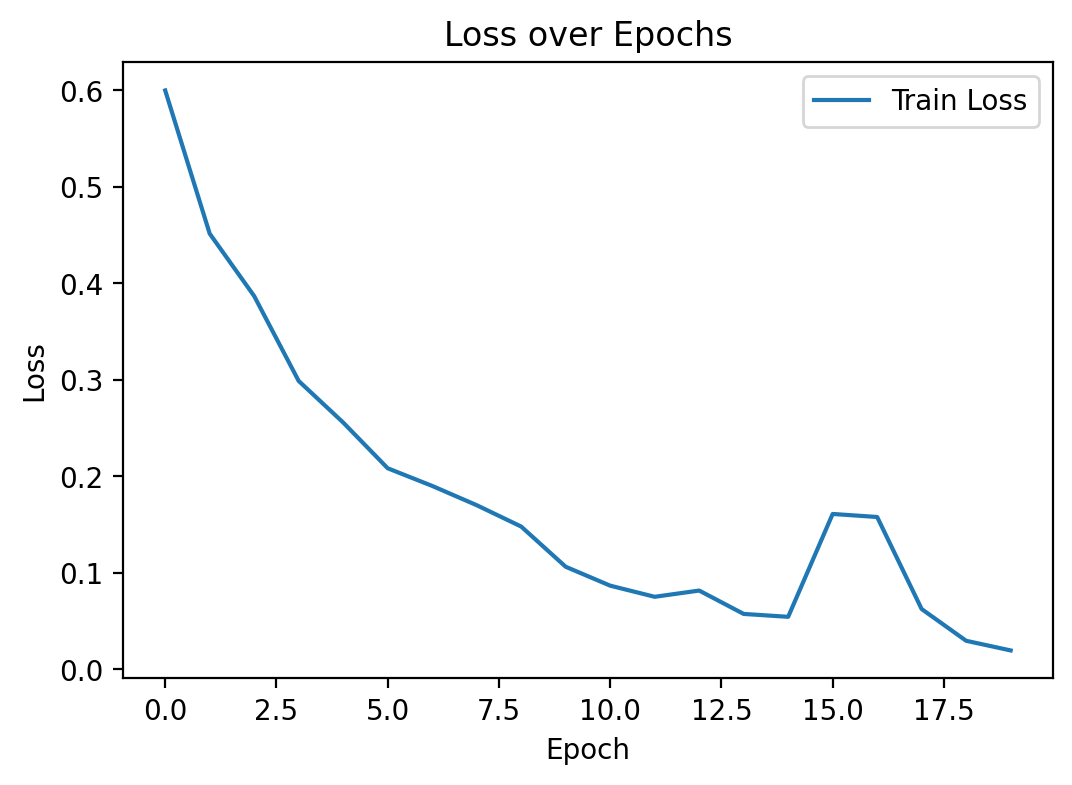

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))

# 7. 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
# 8. 정확도 평가 함수
def evaluate(model, dataloader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

# 9. 테스트 정확도 출력
accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 86.34%


## 학습 종료

### 심화 학습

In [ ]:
# 10. 잘못 예측한 샘플 중 부정(0)을 긍정으로, 긍정(1)을 부정으로 예측한 사례 출력
print("\n오분류 예시:")

model.eval()
false_positive_found = False
false_negative_found = False

with torch.no_grad():
    for i in range(len(x_test_tensor)):
        input_seq = x_test_tensor[i].unsqueeze(0).to(device)
        label = y_test_tensor[i].item()
        output = model(input_seq)
        prediction = 1.0 if output.item() > 0.5 else 0.0

        # 부정(0)을 긍정(1)으로 예측한 경우
        if label == 0.0 and prediction == 1.0 and not false_positive_found:
            print(f"\nFalse Positive (부정을 긍정으로 예측)\n실제 레이블: {int(label)}, 예측: {int(prediction)}")
            print(f"리뷰 토큰: {x_test_tensor[i].tolist()}")
            false_positive_found = True

        # 긍정(1)을 부정(0)으로 예측한 경우
        if label == 1.0 and prediction == 0.0 and not false_negative_found:
            print(f"\nFalse Negative (긍정을 부정으로 예측)\n실제 레이블: {int(label)}, 예측: {int(prediction)}")
            print(f"리뷰 토큰: {x_test_tensor[i].tolist()}")
            false_negative_found = True

        if false_positive_found and false_negative_found:
            break


오분류 예시:

False Negative (긍정을 부정으로 예측)
실제 레이블: 1, 예측: 0
리뷰 토큰: [33, 6, 58, 54, 1270, 431, 748, 7, 32, 2580, 16, 11, 94, 2, 10, 10, 4, 993, 2, 7, 4, 1766, 2634, 2164, 2, 8, 847, 8, 1450, 121, 31, 7, 27, 86, 2663, 2, 16, 6, 465, 993, 2006, 2, 573, 17, 2, 42, 4, 2, 37, 473, 6, 711, 6, 8869, 7, 328, 212, 70, 30, 258, 11, 220, 32, 7, 108, 21, 133, 12, 9, 55, 465, 849, 3711, 53, 33, 2071, 1969, 37, 70, 1144, 4, 5940, 1409, 74, 476, 37, 62, 91, 1329, 169, 4, 1330, 2, 146, 655, 2212, 5, 258, 12, 184, 2, 546, 5, 849, 2, 7, 4, 22, 1436, 18, 631, 1386, 797, 7, 4, 8712, 71, 348, 425, 4320, 1061, 19, 2, 5, 2, 11, 661, 8, 339, 2, 4, 2455, 2, 7, 4, 1962, 10, 10, 263, 787, 9, 270, 11, 6, 9466, 4, 2, 2, 121, 4, 5437, 26, 4434, 19, 68, 1372, 5, 28, 446, 6, 318, 7149, 8, 67, 51, 36, 70, 81, 8, 4392, 2294, 36, 1197, 8, 2, 2, 18, 6, 711, 4, 9909, 26, 2, 1125, 11, 14, 636, 720, 12, 426, 28, 77, 776, 8, 97, 38, 111, 7489, 6175, 168, 1239, 5189, 137, 2, 18, 27, 173, 9, 2399, 17, 6, 2, 428, 2, 232, 11, 4, 8014

## 종료